In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import the dataset after copying it to the local VM

In [2]:
# https://docs.google.com/spreadsheets/d/1VK-Zs72ebK6ddwvDYFN2cA04PDTbVLXJeylmdJ7OxkM/edit#gid=0

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('PGSS2023').get_worksheet(5)

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

[['Name', 'review', 'sentiment'], ['Parth Parikh', 'On Saturday, friends and I went to the Kennywood amusement park and enjoyed riding various roller coasters. After returning, I had a great time continuing to hang out on campus.', 'Positive'], ['Ben Nguyen', 'We cheated at the Arcade and lost $60', 'Negative'], ['Felix Yang', 'We went to Kennywood, it was fun and great', 'Positive'], ['Sooraj Tharumia', 'We got Github CoPilot to install on the local development environment.', 'Positive'], ['Helen Mao', "I can't escape the country accent.", 'Negative'], ['Kamya Rajesh', 'I slept in, watched a movie, had boba, and walked around with my friends.', 'Positive'], ['Yanwei Liu', 'I walked with friends to a crepe shop, but it was closed. We were so sad.', 'Negative'], ['Olina Mukherjee', 'we made Mega Bed and had a sleepover with 10 people in one AC-ed room, it was fun', 'Positive'], ['Lihini Ranaweera', 'My friends and I went to Kennywood and had fun. We decorated a cake and enjoyed it. ', '

In [3]:
# Convert to a DataFrame and render.
import pandas as pd

df = pd.DataFrame.from_records(rows[1:])
df.columns = rows[0]
df

,Name,review,sentiment
0,Parth Parikh,"On Saturday, friends and I went to the Kennywo...",Positive
1,Ben Nguyen,We cheated at the Arcade and lost $60,Negative
2,Felix Yang,"We went to Kennywood, it was fun and great",Positive
3,Sooraj Tharumia,We got Github CoPilot to install on the local ...,Positive
4,Helen Mao,I can't escape the country accent.,Negative
5,Kamya Rajesh,"I slept in, watched a movie, had boba, and wal...",Positive
6,Yanwei Liu,"I walked with friends to a crepe shop, but it ...",Negative
7,Olina Mukherjee,we made Mega Bed and had a sleepover with 10 p...,Positive
8,Lihini Ranaweera,My friends and I went to Kennywood and had fun...,Positive
9,Kofi Anokye,Slept more than 6 hours,Positive


In [4]:
df["sentiment"].value_counts()

Positive    12
Negative     5
Name: sentiment, dtype: int64

In [5]:
df.head()

,Name,review,sentiment
0,Parth Parikh,"On Saturday, friends and I went to the Kennywo...",Positive
1,Ben Nguyen,We cheated at the Arcade and lost $60,Negative
2,Felix Yang,"We went to Kennywood, it was fun and great",Positive
3,Sooraj Tharumia,We got Github CoPilot to install on the local ...,Positive
4,Helen Mao,I can't escape the country accent.,Negative


# Learn to classify the text based on the sentiment response

## Cleanse the text data to remove things that wouldn't have any bearing on sentiment

In [6]:
# Convert all words to lowercase
df["review"] = df["review"].str.lower()

# Remove HTML tags using Beautiful soup
from bs4 import BeautifulSoup
df["review"] = df["review"].apply(lambda review: BeautifulSoup(review, "lxml").text)

# Remove urls
# From https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
import re
df["review"] = df["review"].apply(lambda review: re.sub(r'^https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE))
df["review"] = df["review"].apply(lambda review: re.sub(r'^http?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE))

df.head()

,Name,review,sentiment
0,Parth Parikh,"on saturday, friends and i went to the kennywo...",Positive
1,Ben Nguyen,we cheated at the arcade and lost $60,Negative
2,Felix Yang,"we went to kennywood, it was fun and great",Positive
3,Sooraj Tharumia,we got github copilot to install on the local ...,Positive
4,Helen Mao,i can't escape the country accent.,Negative


In [7]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.5 MB/s eta 0:00:00


In [8]:
# Remove Contractions
import contractions
df["review"] = df["review"].apply(lambda review: contractions.fix(review))

## Create word cloud to get a birds-eye view of the data driven

In [9]:
#Create Word Cloud
from wordcloud import WordCloud, STOPWORDS

all_reviews = " "
positive_reviews = " "
negative_reviews =  ""

stopwords = set(STOPWORDS)


positive_df = df[df["sentiment"]  == "Positive"]
negative_df = df[df["sentiment"]  == "Negative"]

for review in positive_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    positive_reviews  += " ".join(tokens)+" "

for review in negative_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    negative_reviews  += " ".join(tokens)+" "

In [10]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_reviews)

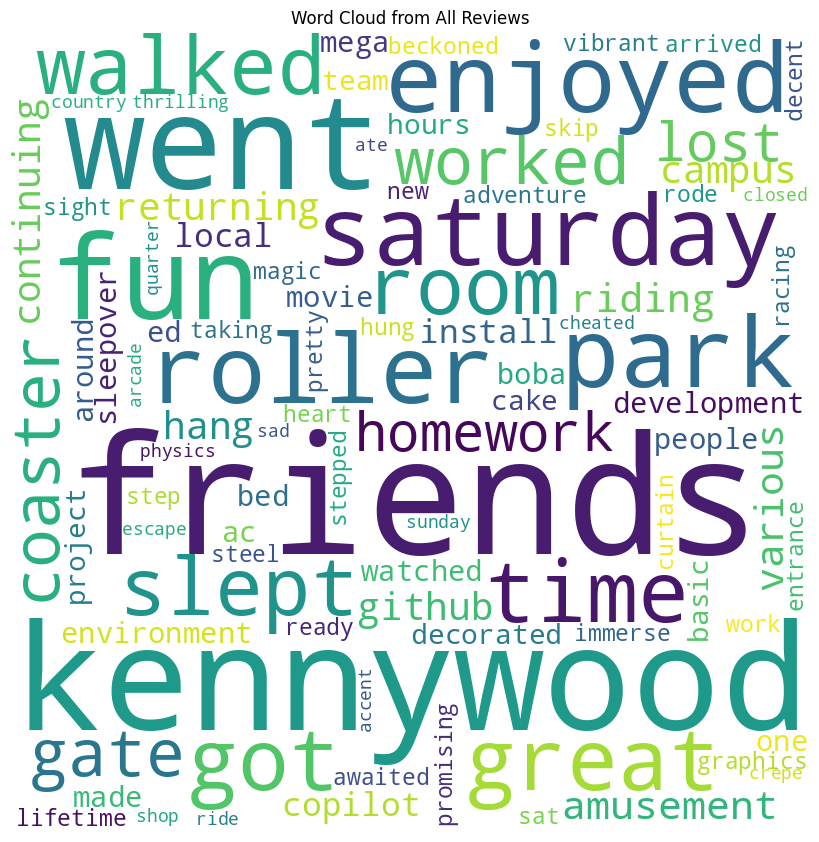

In [11]:
# plot the WordCloud image

import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud from All Reviews")
plt.show()

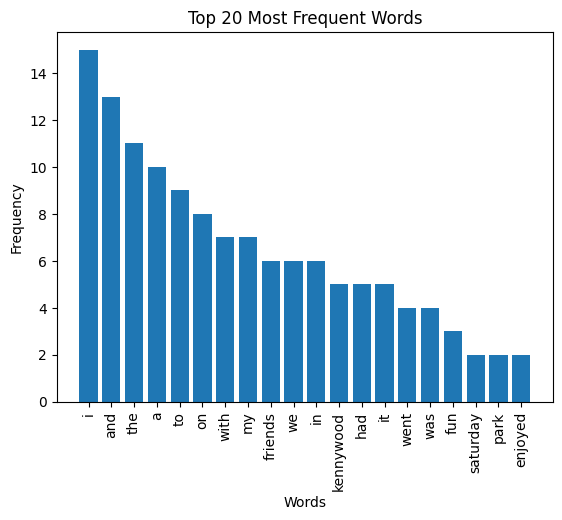

In [12]:
import re
from collections import Counter
import matplotlib.pyplot as plt


def create_barplot(string, k):
    # Step 1: Convert string to list of words
    words = string.split()

    # Step 2: Remove punctuation and special characters
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Step 3: Convert all words to lowercase
    words = [word.lower() for word in words]

    # Step 4: Count frequency of each word using dictionary
    word_counts = Counter(words)

    # Step 5: Sort dictionary by value in descending order and limit to top k
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:k])

    # Step 6: Create barplot using matplotlib
    plt.bar(sorted_word_counts.keys(), sorted_word_counts.values())
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {k} Most Frequent Words')
    plt.show()

k = 20

create_barplot(all_reviews, k)

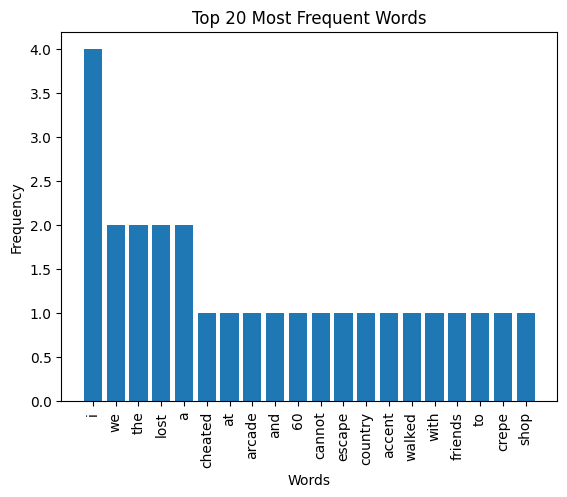

In [13]:
k = 20

create_barplot(negative_reviews, k)

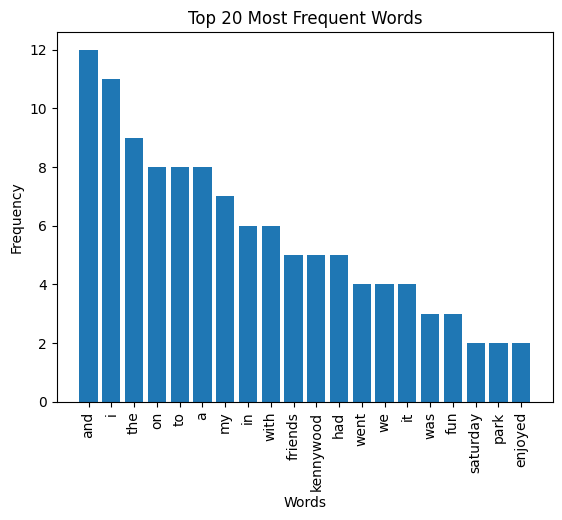

In [14]:
k = 20

create_barplot(positive_reviews, k)

In [15]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the reviews column using apply method
df['num_words'] = df['review'].apply(count_words)

# Create a new column in the dataframe with the number of words
df.head()

,Name,review,sentiment,num_words
0,Parth Parikh,"on saturday, friends and i went to the kennywo...",Positive,30
1,Ben Nguyen,we cheated at the arcade and lost $60,Negative,8
2,Felix Yang,"we went to kennywood, it was fun and great",Positive,9
3,Sooraj Tharumia,we got github copilot to install on the local ...,Positive,11
4,Helen Mao,i cannot escape the country accent.,Negative,6


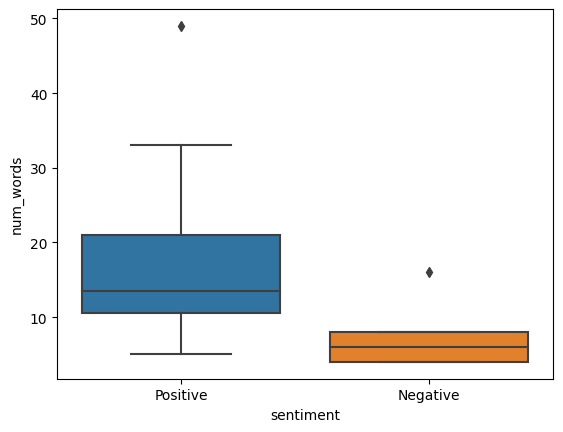

In [16]:
import seaborn as sns

# Create a grouped boxplot using seaborn's boxplot function
sns.boxplot(data=df, x='sentiment', y='num_words')

# Display the plot
plt.show()

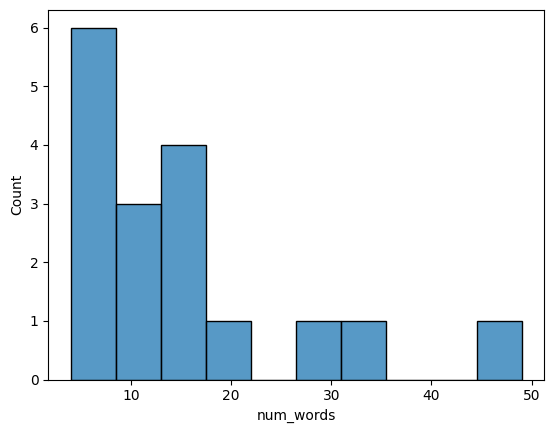

In [17]:
import seaborn as sns

# Create a histogram using seaborn's histplot function
sns.histplot(data=df, x='num_words', bins=10)

# Display the plots
plt.show()

<Axes: xlabel='num_words', ylabel='Density'>

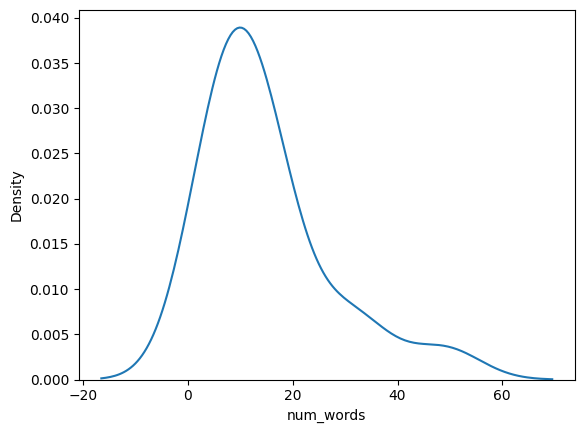

In [18]:
# Create a KDE plot using seaborn's kdeplot function
sns.kdeplot(data=df, x='num_words')

## Create new numerical features in addition to the num_words, using sentence transformers to embed the text into fixed-length numerical representations

In [19]:
! pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d4f37c2890804c285c39d3d2800d86591741207797883769ebf0900334eb7478
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [20]:
# Create a stratified random sample of df
strata = df['sentiment'].unique()

# Calculate the size of the sample for each stratum
sample_size = 5
sample_sizes = {s: sample_size for s in strata}

# Use pandas' groupby method to group the dataframe by the sentiment column
groups = df.groupby('sentiment')

# Use pandas' apply method to sample each group based on the size of the sample for that stratum
samples = groups.apply(lambda x: x.sample(n=sample_sizes[x.name])).reset_index(drop=True)

# Concatenate the sampled groups into a single dataframe
sampled_df = pd.concat([samples])

sampled_df

,Name,review,sentiment,num_words
0,Ben Nguyen,we cheated at the arcade and lost $60,Negative,8
1,Yanwei Liu,"i walked with friends to a crepe shop, but it ...",Negative,16
2,Helen Mao,i cannot escape the country accent.,Negative,6
3,Jessica Hou,i did physics homework,Negative,4
4,Darren Wang,i lost a quarter.,Negative,4
5,Olina Mukherjee,we made mega bed and had a sleepover with 10 p...,Positive,18
6,Kofi Anokye,slept more than 6 hours,Positive,5
7,Parth Parikh,"on saturday, friends and i went to the kennywo...",Positive,30
8,Jack Barsotti (definitely not ChatGPT),"i arrived at kennywood with a skip in my step,...",Positive,49
9,John Beeson,"on saturday, i went to kennywood and rode on t...",Positive,33


In [21]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
sampled_df['embeddings'] = sampled_df['review'].apply(embed_text)

sampled_df

,Name,review,sentiment,num_words,embeddings
0,Ben Nguyen,we cheated at the arcade and lost $60,Negative,8,"[0.1714150309562683, 0.616538941860199, -0.202..."
1,Yanwei Liu,"i walked with friends to a crepe shop, but it ...",Negative,16,"[-0.16504351794719696, 0.5368949174880981, 1.0..."
2,Helen Mao,i cannot escape the country accent.,Negative,6,"[-0.09929081052541733, 0.40072521567344666, 1...."
3,Jessica Hou,i did physics homework,Negative,4,"[-1.1422418355941772, 0.7773445248603821, 0.48..."
4,Darren Wang,i lost a quarter.,Negative,4,"[-0.09921029955148697, 0.28901681303977966, 1...."
5,Olina Mukherjee,we made mega bed and had a sleepover with 10 p...,Positive,18,"[-0.14387217164039612, 0.73602694272995, 0.037..."
6,Kofi Anokye,slept more than 6 hours,Positive,5,"[0.5681650042533875, -0.14679183065891266, 0.7..."
7,Parth Parikh,"on saturday, friends and i went to the kennywo...",Positive,30,"[-0.23665139079093933, -0.4116694927215576, 1...."
8,Jack Barsotti (definitely not ChatGPT),"i arrived at kennywood with a skip in my step,...",Positive,49,"[-0.4658350646495819, -0.19502459466457367, 1...."
9,John Beeson,"on saturday, i went to kennywood and rode on t...",Positive,33,"[-0.6337164640426636, 0.11572985351085663, 1.2..."


In [22]:
df_embeddings = pd.DataFrame(list(sampled_df['embeddings']))

sampled_df = pd.concat([sampled_df, df_embeddings], axis=1)
sampled_df.drop(['embeddings'], axis=1, inplace=True)

# df_model = sampled_df[['num_words', 0, 1, ..., 767]]

sampled_df

,Name,review,sentiment,num_words,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,Ben Nguyen,we cheated at the arcade and lost $60,Negative,8,0.171415,0.616539,-0.202054,0.811134,0.370447,0.262969,...,-0.315388,0.073051,-0.770699,-0.399417,1.135651,-0.010402,-0.308450,-0.420459,0.444750,0.080028
1,Yanwei Liu,"i walked with friends to a crepe shop, but it ...",Negative,16,-0.165044,0.536895,1.078411,-0.229326,-0.227582,0.793055,...,0.080409,-1.047962,-1.118608,-1.558059,0.734870,-1.059605,-0.329513,0.827436,-0.415041,-0.183259
2,Helen Mao,i cannot escape the country accent.,Negative,6,-0.099291,0.400725,1.528112,0.422959,0.362976,0.477545,...,-0.469579,-0.579998,0.519598,-0.467438,0.026643,-1.073532,0.430557,0.617135,-0.339191,0.392273
3,Jessica Hou,i did physics homework,Negative,4,-1.142242,0.777345,0.484067,0.089014,-0.202591,-0.773903,...,0.553019,0.193123,0.024600,-0.636916,0.229543,-0.832591,-0.072314,0.307863,-0.046681,0.364291
4,Darren Wang,i lost a quarter.,Negative,4,-0.099210,0.289017,1.295303,0.865591,0.231174,1.454006,...,0.869373,0.213146,0.494360,-0.342491,0.785657,-0.327578,-0.813334,0.045382,0.674535,0.111358
5,Olina Mukherjee,we made mega bed and had a sleepover with 10 p...,Positive,18,-0.143872,0.736027,0.037367,0.281455,0.494501,-1.076953,...,-0.851258,-1.161659,-0.581674,-0.447503,0.525667,-0.141608,0.625408,0.104810,1.221338,-0.424296
6,Kofi Anokye,slept more than 6 hours,Positive,5,0.568165,-0.146792,0.744466,0.358526,0.210618,-0.448314,...,0.404830,0.027616,0.257842,0.187654,1.013081,-0.407390,-0.252731,-0.399875,0.951630,-0.782846
7,Parth Parikh,"on saturday, friends and i went to the kennywo...",Positive,30,-0.236651,-0.411669,1.803870,0.502376,0.056640,-1.442144,...,-0.458309,-1.342463,-1.151225,-0.869811,0.571280,-2.087171,-0.119997,0.238305,-0.044362,-0.240646
8,Jack Barsotti (definitely not ChatGPT),"i arrived at kennywood with a skip in my step,...",Positive,49,-0.465835,-0.195025,1.415251,0.034033,0.159423,-1.550763,...,-0.305192,-1.370748,-0.735209,-0.795000,-0.084051,-1.249445,-0.012255,-0.095932,-1.135891,-0.295865
9,John Beeson,"on saturday, i went to kennywood and rode on t...",Positive,33,-0.633716,0.115730,1.292326,0.331409,0.249241,-1.088565,...,-0.165748,-0.966395,-1.325157,-0.729721,0.755060,-1.441604,-0.015511,0.436107,0.369498,-0.232183


In [23]:
modelReadyDataset = sampled_df.drop(['review'], axis=1)
modelReadyDataset['sentiment'] = modelReadyDataset['sentiment'].astype('category')
modelReadyDataset

,Name,sentiment,num_words,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,Ben Nguyen,Negative,8,0.171415,0.616539,-0.202054,0.811134,0.370447,0.262969,0.951685,...,-0.315388,0.073051,-0.770699,-0.399417,1.135651,-0.010402,-0.308450,-0.420459,0.444750,0.080028
1,Yanwei Liu,Negative,16,-0.165044,0.536895,1.078411,-0.229326,-0.227582,0.793055,1.722112,...,0.080409,-1.047962,-1.118608,-1.558059,0.734870,-1.059605,-0.329513,0.827436,-0.415041,-0.183259
2,Helen Mao,Negative,6,-0.099291,0.400725,1.528112,0.422959,0.362976,0.477545,0.435892,...,-0.469579,-0.579998,0.519598,-0.467438,0.026643,-1.073532,0.430557,0.617135,-0.339191,0.392273
3,Jessica Hou,Negative,4,-1.142242,0.777345,0.484067,0.089014,-0.202591,-0.773903,0.450627,...,0.553019,0.193123,0.024600,-0.636916,0.229543,-0.832591,-0.072314,0.307863,-0.046681,0.364291
4,Darren Wang,Negative,4,-0.099210,0.289017,1.295303,0.865591,0.231174,1.454006,0.361057,...,0.869373,0.213146,0.494360,-0.342491,0.785657,-0.327578,-0.813334,0.045382,0.674535,0.111358
5,Olina Mukherjee,Positive,18,-0.143872,0.736027,0.037367,0.281455,0.494501,-1.076953,-0.474948,...,-0.851258,-1.161659,-0.581674,-0.447503,0.525667,-0.141608,0.625408,0.104810,1.221338,-0.424296
6,Kofi Anokye,Positive,5,0.568165,-0.146792,0.744466,0.358526,0.210618,-0.448314,-0.097100,...,0.404830,0.027616,0.257842,0.187654,1.013081,-0.407390,-0.252731,-0.399875,0.951630,-0.782846
7,Parth Parikh,Positive,30,-0.236651,-0.411669,1.803870,0.502376,0.056640,-1.442144,-0.585037,...,-0.458309,-1.342463,-1.151225,-0.869811,0.571280,-2.087171,-0.119997,0.238305,-0.044362,-0.240646
8,Jack Barsotti (definitely not ChatGPT),Positive,49,-0.465835,-0.195025,1.415251,0.034033,0.159423,-1.550763,0.278366,...,-0.305192,-1.370748,-0.735209,-0.795000,-0.084051,-1.249445,-0.012255,-0.095932,-1.135891,-0.295865
9,John Beeson,Positive,33,-0.633716,0.115730,1.292326,0.331409,0.249241,-1.088565,-0.288024,...,-0.165748,-0.966395,-1.325157,-0.729721,0.755060,-1.441604,-0.015511,0.436107,0.369498,-0.232183


## Classify the text after converting the response variable into a categorical type

In [24]:
# Create a decision tree to classify sentiment using the remaining columns of modelReadyDataset

modelReadyDataset = modelReadyDataset.drop('num_words', axis=1)
modelReadyDataset = modelReadyDataset.drop('Name', axis=1)
from sklearn.model_selection import train_test_split

X = modelReadyDataset.drop('sentiment', axis=1)
y = modelReadyDataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
from sklearn import metrics

y_pred = dt_classifier.predict(X_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
# print('Precision:', metrics.precision_score(y_test, y_pred))
# print('Recall:', metrics.recall_score(y_test, y_pred))
# print('F1 Score:', metrics.f1_score(y_test, y_pred))


Accuracy: 0.5


In [27]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
    positive       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
